In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import cost_function

# Reward Function Design
***
$E$ is an array of the district buildings' electricity demand, $n$ is the number of buildings in the district and $t$ is the current timestep.

1. __Default__
    $$
    r(t)^\textrm{def} = E(t)
    $$

2. __MARLISA__
    $$
    r(t)^\textrm{marl} = \textrm{sign}\left(r(t)^\textrm{def}\right) \times 0.01 \times \left|{r(t)^\textrm{def}}\right|^2 \times \textrm{max}\left(0, -\sum_{i=1}^{n-1}{r(t)^\textrm{def}_i}\right)
    $$

3. __SAC__
    $$
    r(t)^\textrm{sac} = \left[\textrm{min}\left(0,{r(t)_0^\textrm{def}}^3\right), \dots, \textrm{min}\left(0,{r(t)_{n-1}^\textrm{def}}^3\right)\right]
    $$

4. __Ramping Square__
    $$
    r(t)^\textrm{ramp} = \left[-\left(\left(\sum_{i=0}^{n-1}{r(t)^\textrm{def}_i} - \sum_{i=0}^{n-1}{r(t-1)^\textrm{def}_i}\right)^2\right)_0, \dots, -\left(\left(\sum_{i=0}^{n-1}{r(t)^\textrm{def}_i} - \sum_{i=0}^{n-1}{r(t-1)^\textrm{def}_i}\right)^2\right)_{n-1}\right] \div n
    $$

5. __Exponential__
    $$
    r(t)^\textrm{exp} = \left[\left(-e^{0.0002 \times \sum_{i=0}^{n-1}{-r(t)^\textrm{def}_i}}\right)_0, \dots, \left(-e^{0.0002 \times \sum_{i=0}^{n-1}{-r(t)^\textrm{def}_i}}\right)_{n-1}\right] \div n
    $$

    Where 0.0002 is a scaling factor to avoid high exponents defined as $\frac{\lambda}{50}$. We use $\lambda = 0.01$.

6. __Mixed__
    $$
    r(t)^\textrm{mix} = r(t)^\textrm{ramp} + r(t)^\textrm{exp}
    $$

# Simulation Analysis
***

In [72]:
# get env timeseries
directory = 'data_reward_function_exploration/'
env_timeseries_list = []

for climate_zone_directory in os.listdir(directory):
    if climate_zone_directory.startswith('Climate'):
        climate_zone = climate_zone_directory.split('_')[-1]
        simulation_directory = os.path.join(os.path.join(directory,climate_zone_directory),'reward_function_exploration')

        for filename in os.listdir(simulation_directory):
            if filename.endswith('.pkl'):
                agent = filename.split('-')[0]
                reward = filename.split('.')[0].split('-')[-1]

                with open(os.path.join(simulation_directory,filename),'rb') as f:
                    simulation = pickle.load(f)
                
                # timeseries
                env = simulation['env']
                env_timeseries = pd.DataFrame()
                env_timeseries['net_electric_consumption'] = env.net_electric_consumption
                env_timeseries['net_electric_consumption_no_storage'] = env.net_electric_consumption_no_storage
                env_timeseries['net_electric_consumption_no_pv_no_storage'] = env.net_electric_consumption_no_pv_no_storage
                env_timeseries['electric_consumption_electric_storage'] = env.electric_consumption_electric_storage
                env_timeseries['electric_consumption_dhw_storage'] = env.electric_consumption_dhw_storage
                env_timeseries['electric_consumption_cooling_storage'] = env.electric_consumption_cooling_storage
                env_timeseries['electric_consumption_dhw'] = env.electric_consumption_dhw
                env_timeseries['electric_consumption_cooling'] = env.electric_consumption_cooling
                env_timeseries['electric_consumption_appliances'] = env.electric_consumption_appliances
                env_timeseries['electric_generation'] = env.electric_generation
                env_timeseries['timestep'] = env_timeseries.index
                env_timeseries['agent'] = agent
                env_timeseries['reward'] = reward
                env_timeseries['climate_zone'] = climate_zone

                # cost functions
                env_timeseries['ramping_cost_function'] = env_timeseries['net_electric_consumption'].rolling(
                    window=env_timeseries.shape[0],min_periods=2
                ).apply(lambda x: cost_function.ramping(x),raw=True)
                env_timeseries['load_factor_cost_function'] = env_timeseries['net_electric_consumption'].rolling(
                    window=env_timeseries.shape[0],min_periods=730
                ).apply(lambda x: cost_function.load_factor(x),raw=True)
                env_timeseries['average_daily_peak_cost_function'] = env_timeseries['net_electric_consumption'].rolling(
                    window=env_timeseries.shape[0],min_periods=24
                ).apply(lambda x: cost_function.average_daily_peak(x),raw=True)
                env_timeseries['annual_peak_demand_cost_function'] = env_timeseries['net_electric_consumption'].rolling(
                    window=env_timeseries.shape[0],min_periods=8760
                ).apply(lambda x: cost_function.net_electric_consumption(x),raw=True)
                env_timeseries['net_electric_consumption_cost_function'] = env_timeseries['net_electric_consumption'].rolling(
                    window=env_timeseries.shape[0],min_periods=1
                ).apply(lambda x: cost_function.net_electric_consumption(x),raw=True)

                env_timeseries_list.append(env_timeseries)
                
            else:
                continue

    else:
        continue

env_timeseries = pd.concat(env_timeseries_list,ignore_index=True)

# calculate normalized cost
cost_function_columns = [c for c in env_timeseries.columns if c.endswith('cost_function')]
data = env_timeseries.melt(id_vars=['timestep','climate_zone','reward','agent'],value_vars=cost_function_columns)
data['variable'] += '_norm'
rbc_data = data[data['agent']=='rbc'].copy()
rbc_data = rbc_data.rename(columns={'value':'baseline_value'})
rbc_data = rbc_data.drop(columns=['agent'])
data = pd.merge(data,rbc_data,on=['timestep','climate_zone','reward','variable'],how='left')
data['norm_value'] = data['value']/data['baseline_value']
data = data.pivot_table(index=['timestep','climate_zone','reward','agent'],columns='variable',values='norm_value')
data = data.reset_index()
env_timeseries = pd.merge(env_timeseries,data,on=['timestep','climate_zone','reward','agent'],how='left')

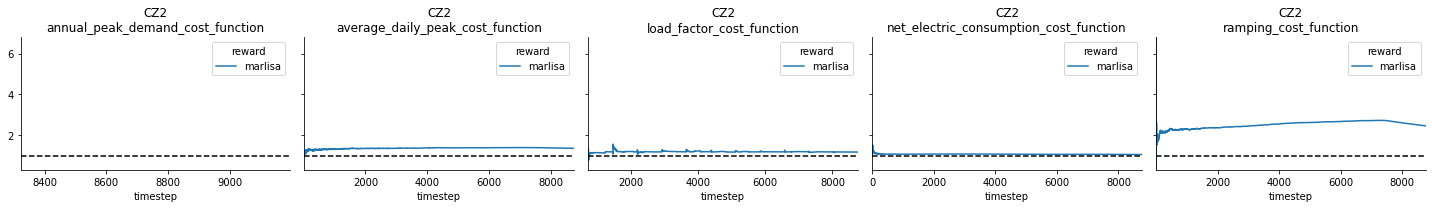

In [73]:
# plot cost function trend
climate_zones = env_timeseries['climate_zone'].unique()
cost_function_columns = [c for c in env_timeseries.columns if c.endswith('cost_function_norm')]
fig, axs = plt.subplots(
    len(climate_zones),
    len(cost_function_columns),
    figsize=(len(cost_function_columns)*4,len(climate_zones)*3),
    sharey = True
)
plot_data = env_timeseries.melt(id_vars=['timestep','climate_zone','reward','agent'],value_vars=cost_function_columns)

for ax, ((climate_zone, cost_function_name) ,group) in zip(fig.axes,plot_data.groupby(['climate_zone','variable'])):
    group = group[group['agent']=='marlisa'].copy()

    for reward, reward_data in group.groupby('reward'):
        x = reward_data['timestep']
        y = reward_data['value']
        ax.plot(x,y,label=reward)
        ax.set_title(f'CZ{climate_zone}\n{cost_function_name.replace("_norm","")}')

    ax.axhline(1,color='black',linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.set_xlabel('timestep')
    ax.legend(title='reward')

plt.tight_layout()
plt.show()

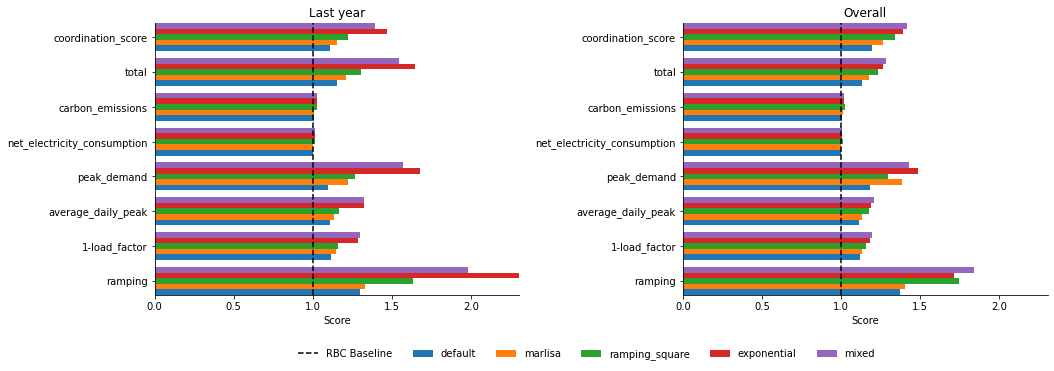

In [12]:
# # cost functions
# fig, axs = plt.subplots(1,2,figsize=(8*2,5),sharey=False,sharex=True,gridspec_kw={'wspace':0.45})
# x_ticks = np.arange(len(
#     simulations[list(simulations.keys())[0]]['env'].cost()[0]
# ))
# overall_cost_x_tick_labels = simulations[list(simulations.keys())[0]]['env'].cost()[0].keys()
# last_year_cost_x_tick_labels = simulations[list(simulations.keys())[0]]['env'].cost()[0].keys()
# width = 0.16

# for i, (style, simulation) in enumerate(simulations.items()):
#     style_x_ticks = [(x_tick - width*len(simulations)/2) + width*(i + 0.5) for x_tick in x_ticks]
#     overall_cost, last_year_cost = simulation['env'].cost()
#     axs[0].barh(style_x_ticks,last_year_cost.values(),width,label=style)
#     axs[1].barh(style_x_ticks,overall_cost.values(),width,label=style)

# for ax, title, y_tick_labels in zip(fig.axes, ['Last year','Overall'], [last_year_cost_x_tick_labels,overall_cost_x_tick_labels]):
#     ax.axvline(1,color='black',linestyle='--',label='RBC Baseline')
#     ax.set_xlabel('Score')
#     ax.set_title(title)
#     ax.set_yticks(x_ticks)
#     ax.set_yticklabels(y_tick_labels)
#     ax.tick_params(axis='y',rotation=0)
#     ax.margins(0)
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)

# fig.axes[0].legend(bbox_to_anchor=(0.5,0),
#     loc='upper center', 
#     bbox_transform=fig.transFigure,
#     framealpha=0,
#     ncol=len(simulations)+1
# )
# # plt.tight_layout()
# plt.show()
